# Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

In [3]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

In [4]:
TRAIN_DATA = 'tmp/taxi-train-v6-chkpt4'
TEST_DATA = 'tmp/taxi-test-v6-chkpt4'

# Helper functions

In [5]:
def split_df(df, y_fld):
    y = df[y_fld].values
    df = df.drop(y_fld, axis=1)
    
    return df, y

# Load data

In [6]:
%%time
train_df = pd.read_feather(TRAIN_DATA)
test_df = pd.read_feather(TEST_DATA)

CPU times: user 1.1 s, sys: 1.49 s, total: 2.6 s
Wall time: 2.59 s


In [7]:
train_df.shape, test_df.shape

((54053965, 15), (9914, 14))

In [8]:
%%time
row_select = 50_000

train_df_sub = train_df[:row_select]
y_train = train_df_sub['fare_amount']
X_train = train_df_sub.drop('fare_amount', axis=1)

CPU times: user 331 µs, sys: 4.39 ms, total: 4.72 ms
Wall time: 4.09 ms


In [9]:
X_train.shape, y_train.shape, test_df.shape

((50000, 14), (50000,), (9914, 14))

# Check if test data is random

## Using random data

In [10]:
X1 = X_train.copy()
X1['is_test'] = 0

(X1.loc[:,'is_test']).sum()

0

In [11]:
n_test = len(test_df)
random = X1.sample(n_test)
X1.loc[random.index,'is_test'] =  1

(X1.loc[:,'is_test']).sum()

9914

In [12]:
x1, y1 = split_df(X1, 'is_test')

In [13]:
%%time
m1 = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m1.fit(x1, y1)
print(m1.oob_score_)

0.79812
CPU times: user 21.8 s, sys: 110 ms, total: 21.9 s
Wall time: 2.06 s


## Using test data

In [14]:
X2 = X_train.copy()
test2 = test_df.copy()

X2['is_test'] = 0
test2['is_test'] = 1

joined_df = pd.concat([X2, test2], sort=False)

In [15]:
x2, y2 = split_df(joined_df, 'is_test')

In [16]:
%%time
m2 = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m2.fit(x2, y2)
print(m2.oob_score_)

0.9086190205961878
CPU times: user 17 s, sys: 82.7 ms, total: 17 s
Wall time: 1.64 s


## Using the model to find data similar as test data

In [17]:
y_train_all = train_df['fare_amount'].copy()
X_train_all = train_df.drop('fare_amount', axis=1)

In [18]:
%%time
pred = m2.predict(X_train_all)

CPU times: user 10min 8s, sys: 3min 40s, total: 13min 49s
Wall time: 1min 6s


In [19]:
pred.sum(), len(pred), len(train_df)

(99825, 54053965, 54053965)

In [20]:
df_similar = train_df.iloc[pred.nonzero()]

In [21]:
len(train_df[pred>0]), len(train_df[pred==0])

(99825, 53954140)

In [22]:
pred_df = pd.DataFrame(pred, columns=['similar'], dtype='uint8')

In [23]:
pred_df.to_feather("tmp/similar_mask")

In [24]:
pred = pd.read_feather("tmp/similar_mask")

In [25]:
# for drawing barchart, so we don't have to retype the following everytime
def draw_barchart(df, title):
    fig = plt.figure(figsize=(20, 4))
    ax = fig.add_subplot(111)
    df.plot(kind='bar')
    ax.set_xlabel("(Year, Month)")
    plt.title(title)
    plt.show()

In [26]:
fare_grouped_df = train_df.fare_amount.groupby([train_df.year,train_df.month])
fare_count_df = fare_grouped_df.count()

test_group_df = test_df.simple_distance.groupby([test_df.year,test_df.month]).count()
similar_grp_df = df_similar.simple_distance.groupby([df_similar.year,df_similar.month]).count()

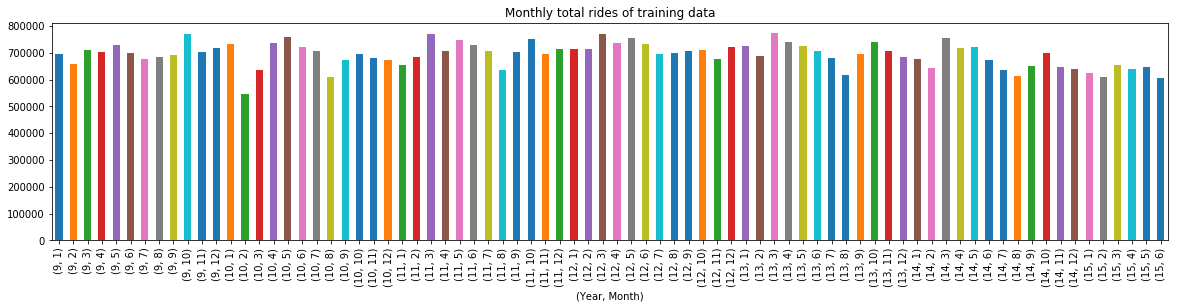

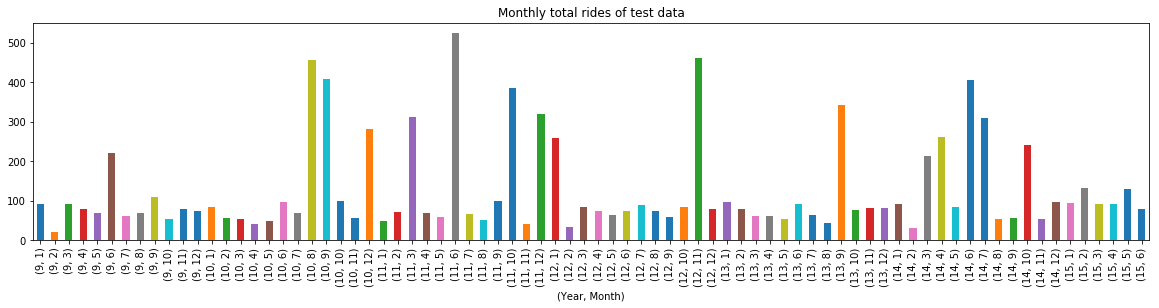

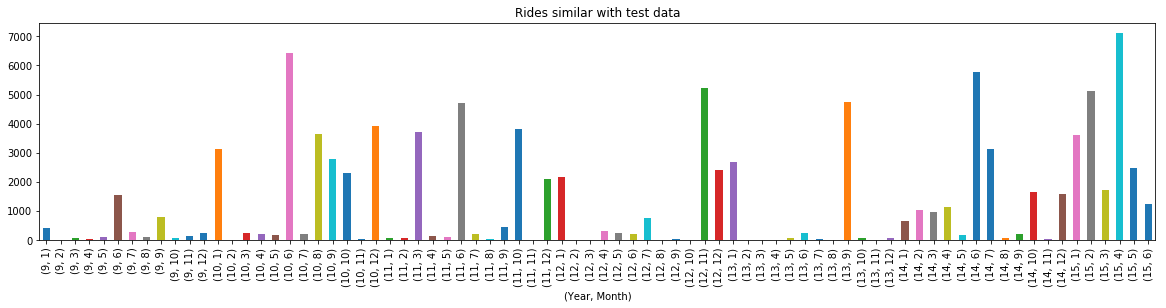

In [27]:
draw_barchart(fare_count_df, 'Monthly total rides of training data')
draw_barchart(test_group_df, 'Monthly total rides of test data')
draw_barchart(similar_grp_df, 'Rides similar with test data')

## Feature Importance

In [ ]:
from fastai.imports import *
from fastai.structured import *

In [ ]:
fi = rf_feat_importance(m, x2)
fi[:10]

In [ ]:
from scipy.cluster import hierarchy as hc

In [ ]:
corr = np.round(scipy.stats.spearmanr(x2).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=x2.columns, orientation='left', leaf_font_size=16)
plt.show()

## Removing top features

In [ ]:
feats = ['hour', 'day', 'week', 'dayofweek']

In [ ]:
x2.drop(feats, axis=1, inplace=True)

In [ ]:
%%time
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x2, y2);
print(m.oob_score_)

In [ ]:
fi = rf_feat_importance(m, x2)

In [ ]:
fi

In [ ]:
x2.drop([], axis=1, inplace=True)

In [ ]:
%%time
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x2, y2);
print(m.oob_score_)

In [ ]:
# m = RandomForestRegressor(n_estimators=10, min_samples_leaf=3, max_features=0.5, n_jobs=-1, random_state=new_seed)
# m.fit(X_train, y_train)
# test_y_predictions = m.predict(test_df)